In [2]:
# Purpose of this notebook:
# Plot polar amplification factor, expressed as a ratio of Arctic to global warming, from WACCM output. Also,
# perform statistical tests to see when it is greater than 0.

# By: Ty Janoski
# Updated: 04.23.2020

In [3]:
# Import statements
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.stats as stats

In [4]:
# create function for taking spatial averages
def spatial_mean(ds_in, lat_bound_s = -91, lat_bound_n = 91):
    """
    Use xarray/numpy to calculate spatial average while weighting for latitude.
    
    Keyword arguments:
    ds_in -- Dataset or DataArray to take the average of
    lat_bound_s -- float, Southern boundary of area to average
    lat_bound_n -- float, Northern boundary of area to average
    """
    zonal = ds_in.mean(dim='lon').sel(lat=slice(lat_bound_s,lat_bound_n))
    weights = np.cos(np.deg2rad(zonal.lat)) / np.sum(np.cos(np.deg2rad(zonal.lat)))
    return((zonal * weights).sum(dim='lat'))

In [5]:
# create function for reading in WACCM output
def read_in(case,exp,mon,ens,var):
    """
    Use xarray to read in a netCDF file.

    Keyword arguments:
    case -- output case prefix (b40.1850, f1850)
    exp -- CO2 scenario
    mon -- starting month in which CO2 is altered
    ens -- ensemble number
    var -- model output variable
    """
    filein = '/dx05/tylerj/d10/Arctic_Research/WACCM/output/'+case+'.scwc.'+exp+'.01.0'+str(
        f"{mon:02d}")+'.0'+str(f"{ens:02d}")+'.h1_'+var+'.nc'
    return(xr.open_dataset(filein,chunks=None))

In [55]:
# Read in piControl data, make a daily climatology only using year 2 values
# Note: the first time step should be discarded, the second value is the FIRST daily average

ctrl = xr.concat([read_in('b40.1850','ctrl',m,e,'TREFHT').isel(time=slice(366,None)) for m in range(1,13,1)
           for e in range(1,11,1)],'run')['TREFHT']

# climatology is produced by grouping by the day of the year. NaN values are excluded
daily_clim = ctrl.groupby('time.dayofyear').mean(dim=['time','run'],skipna=True).load()

# read in abrupt4xCO2 data
TREFHT = xr.open_mfdataset('/dx05/tylerj/d10/Arctic_Research/WACCM/output/b40.1850.scwc.4xCO2.01.001.*_TREFHT.nc',
                          concat_dim='ensemble',combine='nested')['TREFHT'].isel(time=slice(1,None))

# depending on which month we read in, we need to adjust the climatology to start on a certain day of the year
# the following calculation just determines how we have to shift in order to match the starting month
roll_val = -1 * (int(TREFHT['time.dayofyear'].isel(time=0)) - 1)
rolled = daily_clim.roll(dayofyear=roll_val)

# get spatial average of climatology to produce noise later
std_glb = spatial_mean(ctrl.groupby('time.dayofyear').mean(dim='time')).std(dim='run').roll(dayofyear=roll_val)
std_arc = spatial_mean(ctrl.groupby('time.dayofyear').mean(dim='time'),lat_bound_s=70).std(dim='run').roll(dayofyear=roll_val)

num_days = 31

# generate 31 days of random noise based on the std calculated above
noise_glb = np.random.default_rng().normal(loc=0,scale=std_glb,size=(10,365))
noise_arc = np.random.default_rng().normal(loc=0,scale=std_arc,size=(10,365))

# # make the noise the same shape as TREFHT with all values outside first month =0
noise_glb = np.concatenate((noise_glb[:,:num_days],np.zeros((10,len(TREFHT.time) - num_days))),axis=1)
noise_arc = np.concatenate((noise_arc[:,:num_days],np.zeros((10,len(TREFHT.time) - num_days))),axis=1)

# here is the complication: to be able to perform any type of signficance testing, we need to introduce noise into
# the first month (for now) of the 4xCO2 runs.
# This is done by generating a random value from a normal distribution with the standard deviation determined from the same day of the 
# year in year 2 of the control run.(
# The value is then added to one ensemble member for that day. The ensemble mean is set to the unperturbed value.

# take the difference between 4xCO2 and control climatology
diff_jan = TREFHT - np.tile(rolled,(2,1,1))
ens_mean_glb = spatial_mean(diff_jan).mean(dim='ensemble')
ens_mean_arc = spatial_mean(diff_jan,lat_bound_s=70).mean(dim='ensemble')
diff_glb_jan = (ens_mean_glb.broadcast_like(spatial_mean(diff_jan)) + noise_glb).where(
    noise_glb != 0, spatial_mean(diff_jan))
diff_arc_jan = (ens_mean_arc.broadcast_like(spatial_mean(diff_jan)) + noise_arc).where(
    noise_arc != 0, spatial_mean(diff_jan,lat_bound_s=70))

/home/tylerj/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:2812: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [56]:
PAF_mean = (spatial_mean(diff_jan,lat_bound_s=70)/spatial_mean(diff_jan)).mean(dim='ensemble')
PAF_std = (diff_arc_jan/diff_glb_jan).std(dim='ensemble')

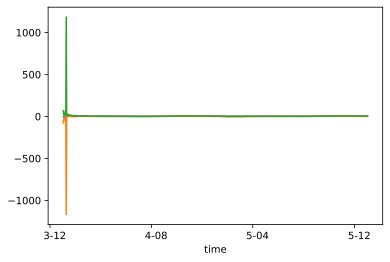

In [57]:
PAF_mean.plot()
(PAF_mean - PAF_std).plot()
(PAF_mean + PAF_std).plot()

In [59]:
abs(diff_glb_jan).min(dim=['ensemble','time']).load()

<xarray.DataArray ()>
array(0.00124419)

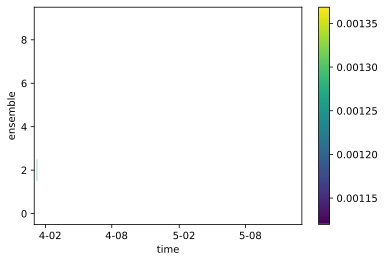

In [63]:
abs(diff_glb_jan).where(abs(diff_glb_jan) == abs(diff_glb_jan).min(dim=['ensemble','time'])).plot()

In [74]:
abs(ens_mean_glb.broadcast_like(spatial_mean(diff_jan)) + noise_glb).min(dim=['ensemble','time']).load()

<xarray.DataArray ()>
array(0.00124419)

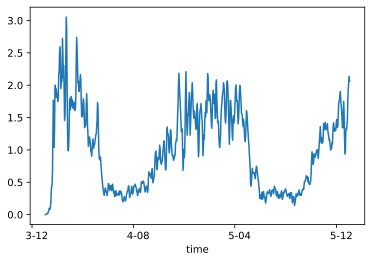

In [76]:
(spatial_mean(diff_jan,lat_bound_s=70) / spatial_mean(diff_jan)).std(dim='ensemble').plot()